In [2]:
#Importing required Python packages
import matplotlib.pylab as plt
import numpy as np
from sklearn import metrics
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import seaborn as sns
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from get_train_test_for_modeling import *
plt.style.use('ggplot')

%matplotlib inline

In [ ]:
filename = '../data/data_X_y_46059_train_w_tide.csv'
Xy_df = get_Xy_data(filename)

cols_to_keep = ['YY_x', 'MM_x', 'DD_x', 'hh_x', 'WD_x', 'WSPD_x',
                'GST_x', 'WVHT_x', 'DPD_x', 'APD_x', 'MWD_x', 'BAR_x', 'ATMP_x',
                'WTMP_x', 'DEWP_x', 'ID_x', 't_arrive', 'WVHT_y']

train_yrs = [1995, 1996, 1997, 1998, 1999, 2000, 2003, 2004, 2006, 2007]
test_yrs  = [2008]

X_train, X_test, y_train, y_test = get_train_test(Xy_df, cols_to_keep, train_yrs, test_yrs)

## functions to get the model fit and pickled

In [ ]:
def model(X_train, y_train):
    
    '''
    This function take in X and y for training
    and will fit a gradient boosted regressor model 
    and return the model
    
    input:
    X_train, y_train
    
    output:
    gradient boosted regressor model that is fit
    
    '''
    n_estimators = 20000
    params = {'n_estimators': n_estimators, 'max_depth': 5, 'min_samples_split': 4,
          'learning_rate': 0.0001, 'loss': 'ls'}
    gbr = GradientBoostingRegressor(**params)
    gbr.fit(X_train, y_train.ravel())
    
    return gbr


def pickle_model(model, filename_to_save):
    '''
    this function will take in a fitted model and save pickle model 
    to the directory
    
    input:
    fitted model
    
    output:
    pickle model
    
    '''
    with open(filename_to_save, 'wb') as f:
       # Write the model to a file.
       pickle.dump(model, f)

def get_X_y_for_hr(hour):
    '''
    take in the hour to make the train and test data for
     
    input: 
    should be on of the following:
    'hr', '24hr', '48hr', '72hr', '96hr', '120hr', '144hr'
    
    output:
    the corresponding train and test data for the hour that was input
    '''
    filename = 'data_X_y_46059_' + hour
    Xy_df = get_Xy_data(filename)
    
    cols_to_keep = ['YY_x', 'MM_x', 'DD_x', 'hh_x', 'WD_x', 'WSPD_x',
                'GST_x', 'WVHT_x', 'DPD_x', 'APD_x', 'MWD_x', 'BAR_x', 'ATMP_x',
                'WTMP_x', 'DEWP_x', 'ID_x', 't_arrive', 'WVHT_y']

    train_yrs = [1995, 1996, 1997, 1998, 1999, 2000, 2003, 2004, 2006, 2007]
    test_yrs  = [2008]

    X_train, X_test, y_train, y_test = get_train_test(Xy_df, cols_to_keep, train_yrs, test_yrs)
    
    return X_train, X_test, y_train, y_test    

## functions to unpickle the model and make predictions

In [26]:
def unpickle_model(pickle_model_name):
    '''
    take in the pickle model and return the unpickle version of it
    
    input:
    pickle model 
    
    output:
    unpickle model
    
    '''
    with open(pickle_model_name, 'rb') as f:
        model = pickle.load(f)
    return model

In [81]:
from get_prediction_data import *

buoyID = 46059
get_prediction_data(buoyID)
prediction_df = clean_prediction_data('../data/data_for_prediction_{}.csv'.format(buoyID))
prediction_df = adding_speed_col(prediction_df, 650)
prediction_df = add_time_delta(prediction_df)
prediction_df = add_time_y(prediction_df)
prediction_df = round_time_y(prediction_df)
prediction_df.to_csv('../data/prediction_df.csv')

prediction_df['ID'] = 46059

cols_to_keep = ['YY', 'MM', 'DD', 'hh', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD',
                'APD','MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'ID', 't_arrive']

predict_hrs = [hr for hr in range(24,166,24)]
for hr in predict_hrs:
    prediction_df['time_delta_{}'.format(str(hr))] = prediction_df['t_arrive'].apply(lambda x: datetime.timedelta((x+hr)/24))
    prediction_df['time_y_{}'.format(str(hr))] = prediction_df.index + prediction_df['time_delta_{}'.format(hr)]
    prediction_df['time_y_hr_{}'.format(hr)]  = prediction_df['time_y_{}'.format(hr)].apply(lambda dt: datetime.datetime(dt.year,
                                                                                             dt.month,
                                                                                             dt.day,
                                                                                             dt.hour,
                                                                                             0,0))
X_real_time_predictions = prediction_df[cols_to_keep].values

pkl_lst = ['gbr_hr.pkl','gbr_24hr.pkl']#,'gbr_48hr.pkl','gbr_72hr.pkl',
           #'gbr_96hr.pkl','gbr_120hr.pkl', 'gbr_144hr.pkl']

datecol = ['hr', 'hr_24']#, 'hr_48', 'hr_72', 'hr_96', 'hr_120', 'hr_144']
df_lst_7day_pred = []
for i, model in enumerate(pkl_lst):
    
    date_col = 'time_y_' + datecol[i]
    
    gbr = unpickle_model(model)
    y_hat = gbr.predict(X_real_time_predictions)
    
    df = prediction_df[[date_col]]
    df['yhat'] = y_hat
    df['offshore_date'] = df.index
    df.index = df[date_col]
    df_lst_7day_pred.append(df)

df_7day_pred = pd.concat(df_lst_7day_pred, axis=0)
df_7day_pred.to_csv('predictions_7days.csv')

In [78]:
prediction_df.head(2)

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,...,time_y_hr_72,time_delta_96,time_y_96,time_y_hr_96,time_delta_120,time_y_120,time_y_hr_120,time_delta_144,time_y_144,time_y_hr_144
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-04 11:00:00,2018,2,4,11,10,10.0,6.0,8.0,1.7,13.0,...,2018-02-08 05:00:00,4 days 18:39:07.914400,2018-02-09 05:39:07.914400,2018-02-09 05:00:00,5 days 18:39:07.914400,2018-02-10 05:39:07.914400,2018-02-10 05:00:00,6 days 18:39:07.914400,2018-02-11 05:39:07.914400,2018-02-11 05:00:00
2018-02-04 11:00:00,2018,2,4,11,0,10.0,6.0,7.0,1.7,13.0,...,2018-02-08 05:00:00,4 days 18:39:07.914400,2018-02-09 05:39:07.914400,2018-02-09 05:00:00,5 days 18:39:07.914400,2018-02-10 05:39:07.914400,2018-02-10 05:00:00,6 days 18:39:07.914400,2018-02-11 05:39:07.914400,2018-02-11 05:00:00


In [32]:
gbr_hr = unpickle_model('gbr_hr.pkl')
gbr_24hr = unpickle_model('gbr_24hr.pkl')

In [ ]:
y_hat_hr = gbr_hr.predict(X_real_time_predictions )
y_hat_24hr = gbr_24hr.predict(X_real_time_predictions )

In [65]:
df_hr = prediction_df[['time_y_hr']]
df_hr['yhat'] = y_hat_hr
df_hr['offshore_date'] = df_hr.index
df_hr.index = df_hr['time_y_hr']

df_24hr = prediction_df[['time_y_hr_24']]
df_24hr['yhat'] = y_hat_24hr
df_24hr['offshore_date'] = df_24hr.index
df_24hr.index = df_24hr['time_y_hr_24']

In [80]:
df_24hr.head()

,time_y_hr_24,yhat,offshore_date
time_y_hr_24,,,
2018-02-06 05:00:00,2018-02-06 05:00:00,1.931303,2018-02-04 11:00:00
2018-02-06 05:00:00,2018-02-06 05:00:00,1.931303,2018-02-04 11:00:00
2018-02-06 04:00:00,2018-02-06 04:00:00,1.931303,2018-02-04 10:00:00
2018-02-06 04:00:00,2018-02-06 04:00:00,1.931303,2018-02-04 10:00:00
2018-02-06 05:00:00,2018-02-06 05:00:00,1.931303,2018-02-04 10:00:00


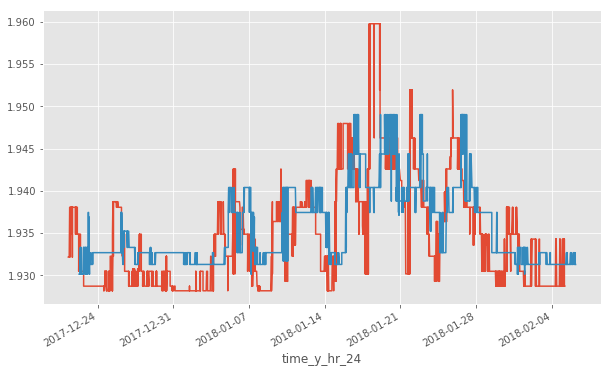

In [69]:
fig, ax = plt.subplots(figsize = (10,6))
df_hr['yhat'].plot()
df_24hr['yhat'].plot()